In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib import cycler

# Define Prometheus server URL
prometheus_url = 'http://localhost:9090'  # Replace with your actual Prometheus server URL

# Define Prometheus queries
cpu_query = 'sum(irate(node_cpu_seconds_total{instance="node-exporter:9100", job="node_exporter", mode!="idle"}[5m])) / scalar(count(count(node_cpu_seconds_total{instance="node-exporter:9100", job="node_exporter"}) by (cpu)))'
ram_query = 'node_memory_MemAvailable_bytes{instance="node-exporter:9100", job="node_exporter"} / node_memory_MemTotal_bytes{instance="node-exporter:9100", job="node_exporter"}'

# Function to fetch data from Prometheus
def fetch_data(query, start, end):
    response = requests.get(f'{prometheus_url}/api/v1/query_range', params={
        'query': query,
        'start': start,
        'end': end,
        'step': '1s'
    })
    response.raise_for_status()  # Check for request errors
    results = response.json()['data']['result']
    print(f"Data for interval {start} to {end}: {results}")
    return results

# Function to process Prometheus data
def process_data(data):
    if not data:
        print("No data returned from Prometheus.")
        return [], []
    timestamps = [pd.to_datetime(point[0], unit='s') for point in data[0]['values']]
    values = [float(point[1]) for point in data[0]['values']]
    return timestamps, values

# Normalize timestamps to start from 0
def normalize_timestamps(timestamps):
    start_time = timestamps[0] if timestamps else None
    return [(ts - start_time).total_seconds() for ts in timestamps], start_time

# Function to plot grouped data
def plot_grouped_data(data_groups, ylabel, title, output_file):
    plt.figure(figsize=(14, 7))
    
    # Set a color cycle
    plt.rc('axes', prop_cycle=(cycler('color', plt.cm.tab20.colors)))

    for normalized_timestamps, values, label in data_groups:
        plt.plot(normalized_timestamps, values, label=label)

    plt.xlabel('Seconds from Start')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Create directories if they do not exist
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    # Save and show the plot
    plt.savefig(output_file, dpi=300)
    plt.show()

def plot_avg_data(values, labels, ylabel, title, output_file, variable_name, is_throughput=False):
    plt.figure(figsize=(14, 7))

    # Set a color cycle
    plt.rc('axes', prop_cycle=(cycler('color', plt.cm.tab20.colors)))

    if is_throughput:
        # Determine the appropriate unit for throughput
        max_throughput = max(values)
        if max_throughput > 1000000:
            throughput_unit = "MB/s"
            values = [v / (1024 * 1024) for v in values]
        elif max_throughput > 1000:
            throughput_unit = "KB/s"
            values = [v / 1024 for v in values]
        else:
            throughput_unit = "B/s"
        ylabel = f'Average Throughput ({throughput_unit})'

    plt.plot(labels, values, marker='o')
    
    for i, value in enumerate(values):
        plt.text(labels[i], value, f'{value:.2f}', ha='center', va='bottom')

    plt.xlabel(variable_name)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()

    # Create directories if they do not exist
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    # Save and show the plot
    plt.savefig(output_file, dpi=300)
    plt.show()


def compare_performance(test_cases):
    results = []
    for case in test_cases:
        data_type_name, http_version, parallel_count, num_repeats, network_latency = case
        route = f"data/performance/{data_type_name}_{http_version}_{parallel_count}_{num_repeats}_{network_latency}ms.sh"

        if not os.path.isfile(route):
            print(f"File {route} does not exist.")
            continue

        # Read the CSV file
        df = pd.read_csv(route)

        # Extract necessary data
        start_time = df.loc[df.index[0], 'start_time']
        end_time = df.loc[df.index[0], 'end_time']
        total_average_latency = df.loc[df.index[0], 'total_average_latency']
        total_average_throughput = df.loc[df.index[0], 'total_average_throughput']

        # Collect results
        results.append({
            'data_type_name': data_type_name,
            'http_version': http_version,
            'parallel_count': parallel_count,
            'num_repeats': num_repeats,
            'network_latency': network_latency,
            'start_time': start_time,
            'end_time': end_time,
            'total_average_latency': total_average_latency,
            'total_average_throughput': total_average_throughput
        })

    # Set time intervals according to start and end times of the cases in the group
    time_intervals = [(result['start_time'], result['end_time']) for result in results]

    return results, time_intervals

def perform_comparison(test_cases, variable_name):
    results, time_intervals = compare_performance(test_cases)

    # Print results
    for result in results:
        print(f"Data Type: {result['data_type_name']}, HTTP Version: {result['http_version']}, "
              f"Parallel Count: {result['parallel_count']}, Number of Repeats: {result['num_repeats']}, "
              f"Network Latency: {result['network_latency']} ms")
        print(f"Start Time: {result['start_time']}, End Time: {result['end_time']}, "
              f"Total Average Latency: {result['total_average_latency']}, "
              f"Total Average Throughput: {result['total_average_throughput']}")
        print()

    # Create a string for data type names
    variable_list = "_".join([case[0] for case in test_cases])

    # Prepare data for plotting
    cpu_data_groups = []
    ram_data_groups = []
    avg_latency = []
    avg_throughput = []
    avg_cpu_usage = []
    avg_ram_usage = []
    labels = []

    for result in results:
        data_type_name = result['data_type_name']
        start_time = result['start_time']
        end_time = result['end_time']

        labels.append(data_type_name)
        avg_latency.append(result['total_average_latency'])
        avg_throughput.append(result['total_average_throughput'])

        # Fetch CPU data
        cpu_data = fetch_data(cpu_query, start_time, end_time)
        cpu_timestamps, cpu_values = process_data(cpu_data)
        cpu_normalized_timestamps, _ = normalize_timestamps(cpu_timestamps)
        cpu_data_groups.append((cpu_normalized_timestamps, cpu_values, data_type_name))
        avg_cpu_usage.append(sum(cpu_values) / len(cpu_values))

        # Fetch RAM data
        ram_data = fetch_data(ram_query, start_time, end_time)
        ram_timestamps, ram_values = process_data(ram_data)
        ram_normalized_timestamps, _ = normalize_timestamps(ram_timestamps)
        ram_data_groups.append((ram_normalized_timestamps, ram_values, data_type_name))
        avg_ram_usage.append(sum(ram_values) / len(ram_values))

    # Plot CPU usage comparison
    cpu_output_file = f"data/performance/cpu/{variable_list}_{test_cases[0][1]}_{test_cases[0][2]}_{test_cases[0][3]}_{test_cases[0][4]}ms.png"
    plot_grouped_data(cpu_data_groups, 'CPU Usage (%)', 'CPU Usage Comparison', cpu_output_file)

    # Plot RAM usage comparison
    ram_output_file = f"data/performance/ram/{variable_list}_{test_cases[0][1]}_{test_cases[0][2]}_{test_cases[0][3]}_{test_cases[0][4]}ms.png"
    plot_grouped_data(ram_data_groups, 'RAM Usage (%)', 'RAM Usage Comparison', ram_output_file)

    # Plot average latency
    avg_latency_output_file = f"data/performance/latency/{variable_list}_{test_cases[0][1]}_{test_cases[0][2]}_{test_cases[0][3]}_{test_cases[0][4]}ms.png"
    plot_avg_data(avg_latency, labels, 'Average Latency (s)', 'Average Latency Comparison', avg_latency_output_file, variable_name)

    # Plot average throughput
    avg_throughput_output_file = f"data/performance/throughput/{variable_list}_{test_cases[0][1]}_{test_cases[0][2]}_{test_cases[0][3]}_{test_cases[0][4]}ms.png"
    plot_avg_data(avg_throughput, labels, 'Average Throughput', 'Average Throughput Comparison', avg_throughput_output_file, variable_name, is_throughput=True)

    # Plot average CPU usage
    avg_cpu_usage_output_file = f"data/performance/avg_cpu_usage/{variable_list}_{test_cases[0][1]}_{test_cases[0][2]}_{test_cases[0][3]}_{test_cases[0][4]}ms.png"
    plot_avg_data(avg_cpu_usage, labels, 'Average CPU Usage (%)', 'Average CPU Usage Comparison', avg_cpu_usage_output_file, variable_name)

    # Plot average RAM usage
    avg_ram_usage_output_file = f"data/performance/avg_ram_usage/{variable_list}_{test_cases[0][1]}_{test_cases[0][2]}_{test_cases[0][3]}_{test_cases[0][4]}ms.png"
    plot_avg_data(avg_ram_usage, labels, 'Average RAM Usage (%)', 'Average RAM Usage Comparison', avg_ram_usage_output_file, variable_name)









Data Type: text, HTTP Version: http1, Parallel Count: 3, Number of Repeats: 20, Network Latency: 0 ms
Start Time: 1722275977.139581, End Time: 1722275980.59925, Total Average Latency: 0.1230750997861226, Total Average Throughput: 277.4831836803551

Data Type: picture, HTTP Version: http1, Parallel Count: 3, Number of Repeats: 20, Network Latency: 0 ms
Start Time: 1722275980.963647, End Time: 1722275984.089821, Total Average Latency: 0.1019157489140828, Total Average Throughput: 2593022.47781805

Data Type: video, HTTP Version: http1, Parallel Count: 3, Number of Repeats: 20, Network Latency: 0 ms
Start Time: 1722270660.8690932, End Time: 1722270709.2771504, Total Average Latency: 0.0456365790632036, Total Average Throughput: 23221841.66692964

Data for interval 1722275977.139581 to 1722275980.59925: [{'metric': {}, 'values': [[1722275977.14, '0.006833333333333875'], [1722275978.14, '0.006833333333333875'], [1722275979.14, '0.005001000200040138'], [1722275980.14, '0.005001000200040138']

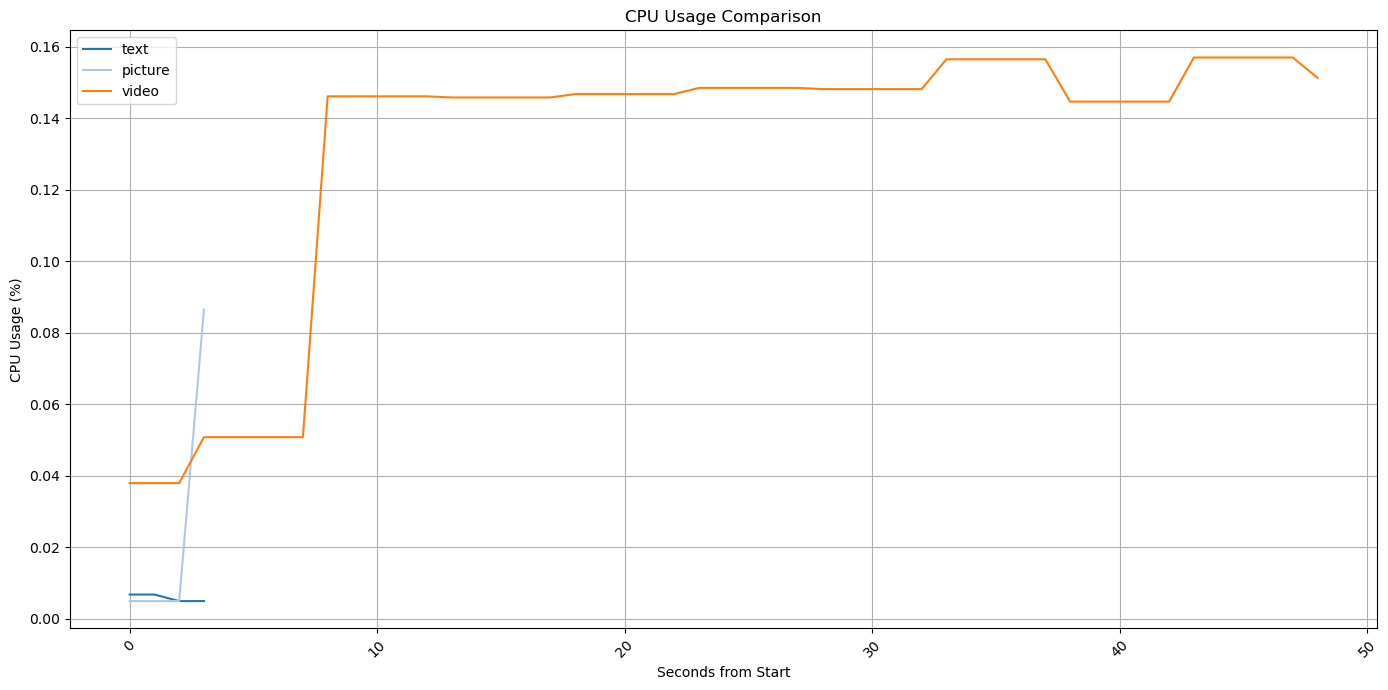

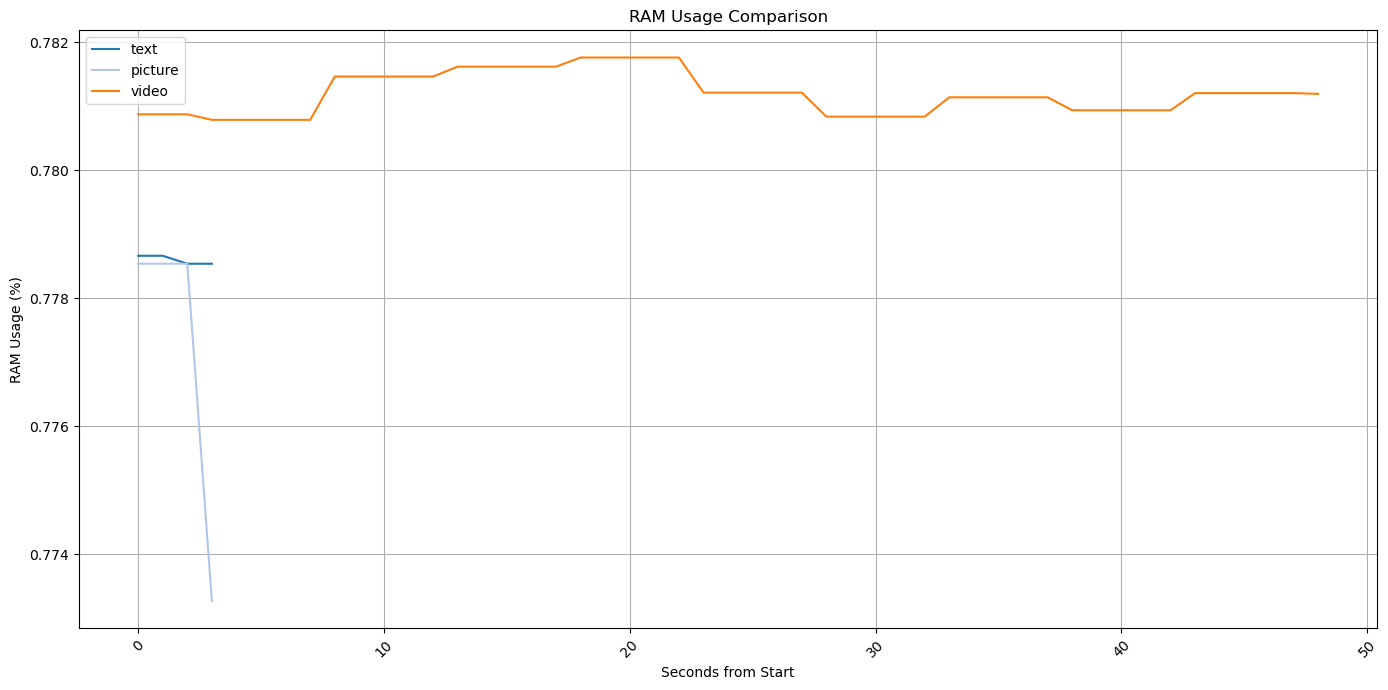

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


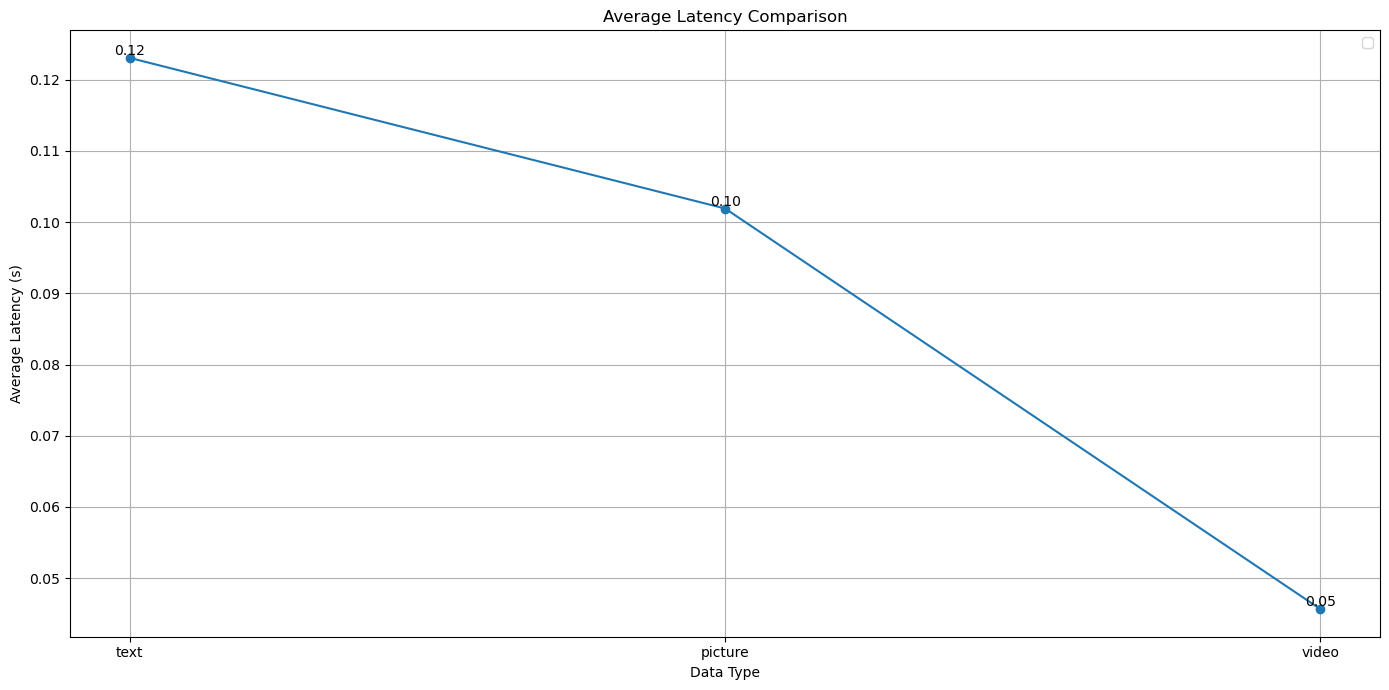

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


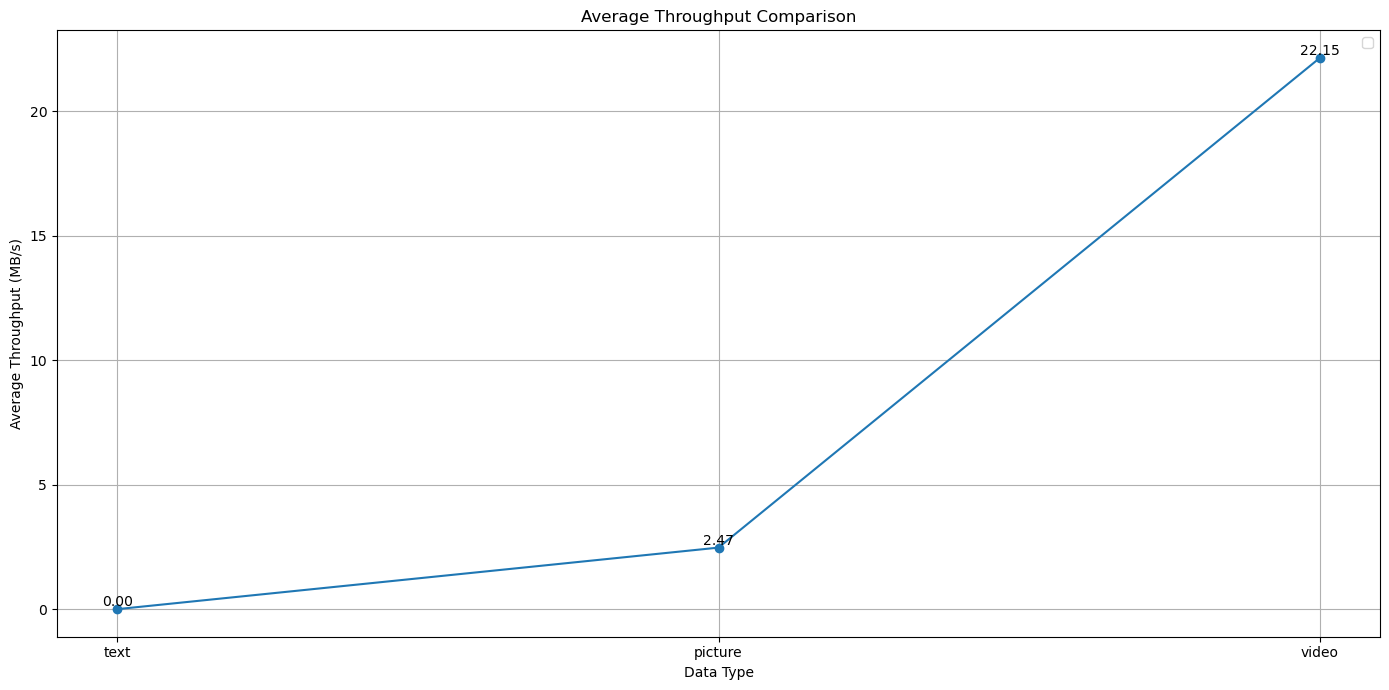

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


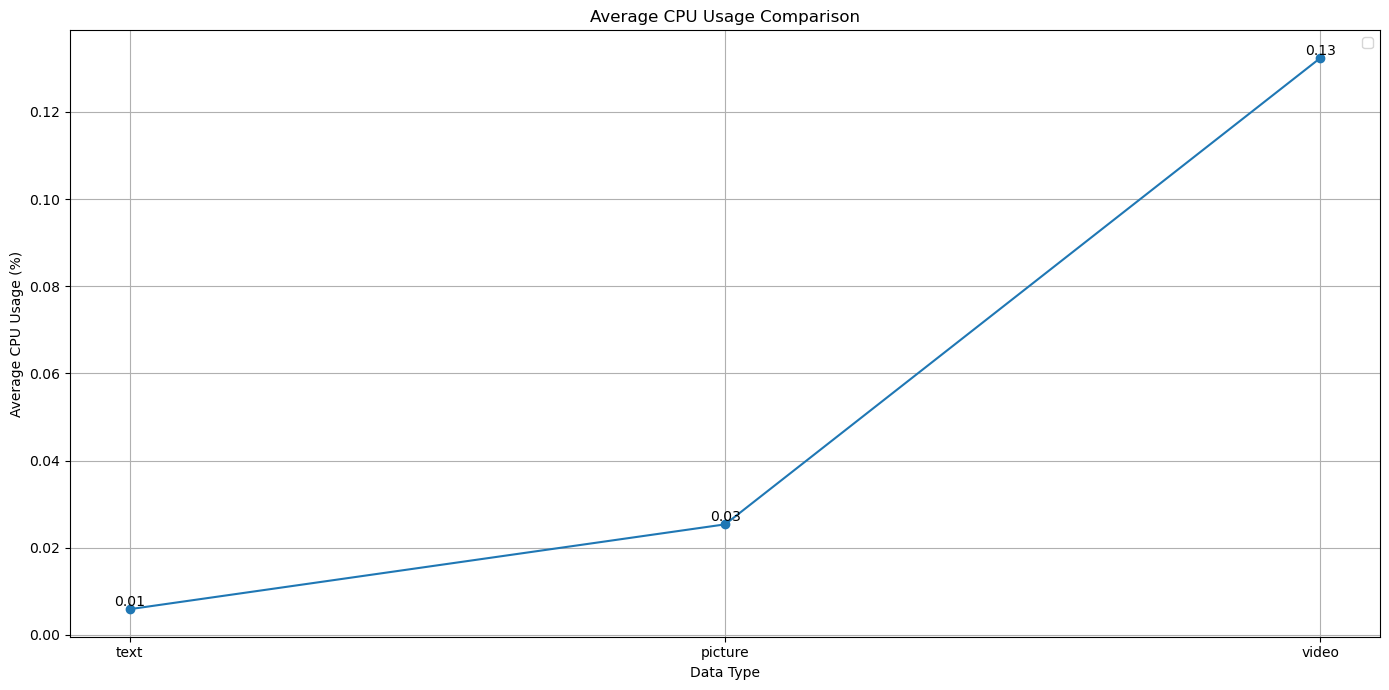

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


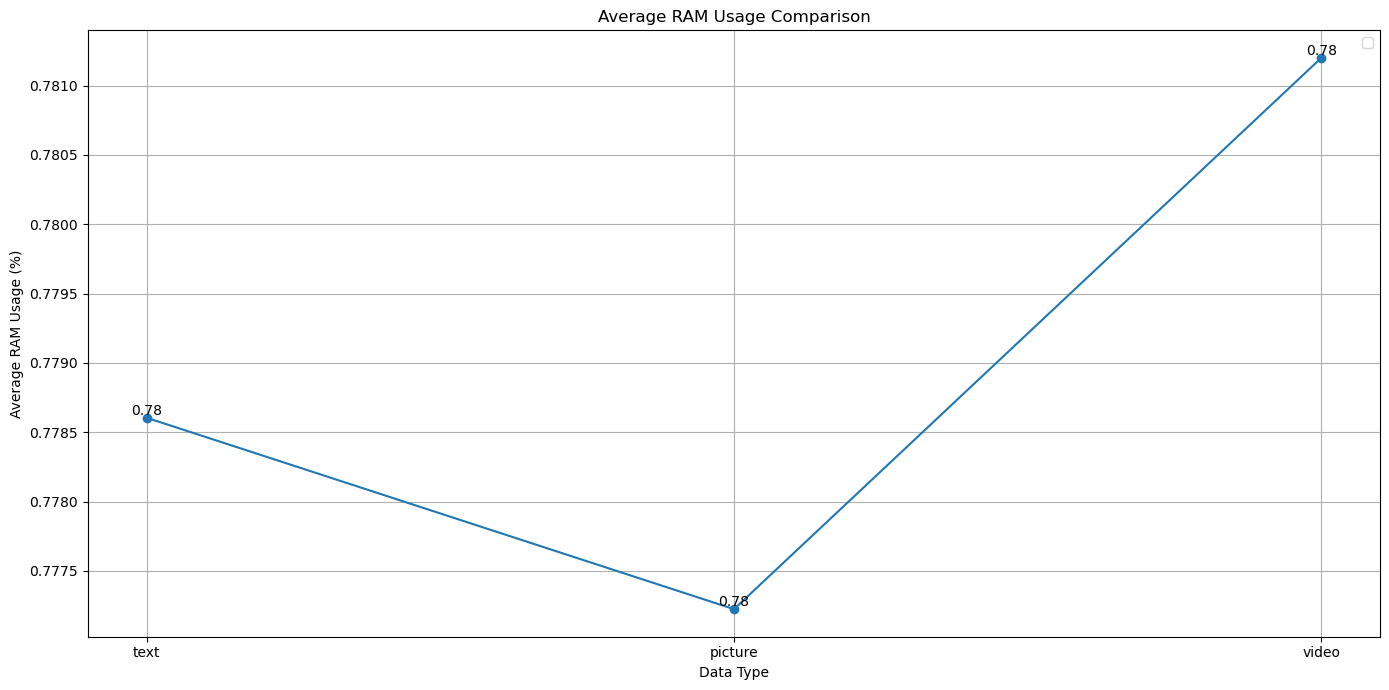

In [2]:
def main():
    # Constants
    http_version = "http1"
    network_latency = 0  # in milliseconds
    parallel_count = 3
    num_repeats = 20

    # Variable parameter and its values
    data_types = ["text", "picture", "video"]  # Variable parameter
    variable_name = "Data Type"

    # Create an array of data
    test_cases = [(data_type, http_version, parallel_count, num_repeats, network_latency) for data_type in data_types]

    # Execute comparison
    perform_comparison(test_cases, variable_name)

if __name__ == "__main__":
    main()

In [26]:
def main_with_direct_data():
    # Directly specify the data cases
    test_cases = [
        ("text", "http1", 3, 20, 0),
        ("picture", "http1", 3, 20, 0),
        ("video", "http1", 3, 20, 0)
    ]
    variable_name = "Data Type"

    # Execute comparison
    perform_comparison(test_cases, variable_name)

if __name__ == "__main__":
    main_with_direct_data()